In [1]:
!pip install --upgrade pip

In [2]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
# !pip install torchcodec
!pip install -U typing_extensions

import torch; torch._dynamo.config.recompile_limit = 64;

In [3]:
%%capture
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [4]:
!pip install wandb

In [5]:
import wandb
wandb.login() # You will be prompted to enter your API Key here

# Initialize a project
run = wandb.init(
    project="Finetune-gemma3n", # Give your project a name
    name="gemma-3n-finetune-500train-run-2",   # Name this specific run
)

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

  2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sarangavp20 (vlm-blind-assist) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3n-E4B-it",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.9: Fast Gemma3N patching. Transformers: 4.56.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.422 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

In [7]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 204.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 203.2 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3━━━━━ 0/2 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]


In [ ]:
from huggingface_hub import login
import os

# Paste your token here (get it from: https://huggingface.co/settings/tokens)
HF_TOKEN = "" 

login(token=HF_TOKEN)

In [9]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 64,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 128,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [10]:
!pip uninstall torchcodec -y

In [11]:
# from datasets import load_dataset, Video

# dataset = load_dataset("blind-assist/walk", split="test").cast_column("video", Video(decode=False))
# dataset = dataset.select(range(50))

from datasets import load_dataset, DatasetDict, Video, Dataset
from itertools import islice

dataset_stream = load_dataset(
    "blind-assist/walk-train",
    split="train",
    streaming=True
)

dataset_stream = dataset_stream.cast_column("video", Video(decode=False))

from huggingface_hub import hf_hub_download
import os

SAVE_DIR = "videos"
os.makedirs(SAVE_DIR, exist_ok=True)

N = 500  # first 500 videos
local_data = []

for item in islice(dataset_stream, N):
    video_hf_path = item["video"]["path"]
    filename = video_hf_path.split("/")[-1]
    local_path = os.path.join(SAVE_DIR, "train", filename)

    # download if not exists
    if not os.path.exists(local_path):
        hf_hub_download(
            repo_id="blind-assist/walk-train",
            filename=f"train/{filename}",
            repo_type="dataset",
            local_dir=SAVE_DIR,
            local_dir_use_symlinks=False
        )

    # replace video path in the item
    item["video"]["path"] = local_path
    local_data.append(item)


dataset = Dataset.from_list(local_data)

Resolving data files:   0%|          | 0/8582 [00:00<?, ?it/s]

train/20240918-youtube_short_fe880bc6cb4(…):   0%|          | 0.00/2.79M [00:00<?, ?B/s]

train/20240918-youtube_short_27d4d241260(…):   0%|          | 0.00/1.94M [00:00<?, ?B/s]

train/20240918-youtube_short_d6c818eee22(…):   0%|          | 0.00/3.42M [00:00<?, ?B/s]

train/20240918-youtube_short_94773cc21cc(…):   0%|          | 0.00/2.94M [00:00<?, ?B/s]

train/20240918-youtube_short_4f846a8342b(…):   0%|          | 0.00/2.77M [00:00<?, ?B/s]

train/20240914_d288d35e621454988dd7d35e1(…):   0%|          | 0.00/728k [00:00<?, ?B/s]

train/20240918-youtube_short_24f6e071322(…):   0%|          | 0.00/3.79M [00:00<?, ?B/s]

train/20240918-youtube_short_f622f46528a(…):   0%|          | 0.00/1.57M [00:00<?, ?B/s]

train/20240918-youtube_short_ba5c3e7f9b0(…):   0%|          | 0.00/2.54M [00:00<?, ?B/s]

train/20240918-youtube_short_2a0137567d5(…):   0%|          | 0.00/3.16M [00:00<?, ?B/s]

train/20240918-youtube_short_11bc0f3b2d7(…):   0%|          | 0.00/2.65M [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/2.46M [00:00<?, ?B/s]

train/20240918-youtube_short_2f2ffc86e63(…):   0%|          | 0.00/1.94M [00:00<?, ?B/s]

train/20240918-youtube_short_63f903c7cce(…):   0%|          | 0.00/2.81M [00:00<?, ?B/s]

train/20240918-youtube_short_00a696f1175(…):   0%|          | 0.00/3.04M [00:00<?, ?B/s]

train/20240918-youtube_short_00a696f1175(…):   0%|          | 0.00/2.48M [00:00<?, ?B/s]

train/20240918-youtube_short_00a696f1175(…):   0%|          | 0.00/3.09M [00:00<?, ?B/s]

train/20240918-youtube_short_6d446c74d32(…):   0%|          | 0.00/2.13M [00:00<?, ?B/s]

train/20240918-youtube_short_5e56faceeb7(…):   0%|          | 0.00/4.61M [00:00<?, ?B/s]

train/20240918_short_cb95ca56064dd185787(…):   0%|          | 0.00/388k [00:00<?, ?B/s]

train/20240918-youtube_short_4b9086a0480(…):   0%|          | 0.00/2.67M [00:00<?, ?B/s]

train/20240918-youtube_short_21957577e02(…):   0%|          | 0.00/2.04M [00:00<?, ?B/s]

train/20240914_6925d2d7fb9f9a79a792b479b(…):   0%|          | 0.00/957k [00:00<?, ?B/s]

train/20240918-youtube_short_81ae432f1ab(…):   0%|          | 0.00/4.03M [00:00<?, ?B/s]

train/20240918-youtube_short_7c2e0a9585c(…):   0%|          | 0.00/4.05M [00:00<?, ?B/s]

train/20240918-youtube_short_d6c818eee22(…):   0%|          | 0.00/3.58M [00:00<?, ?B/s]

train/20240918_short_51dadffcfe8e352852f(…):   0%|          | 0.00/498k [00:00<?, ?B/s]

train/20240918-youtube_short_f61385006f2(…):   0%|          | 0.00/3.50M [00:00<?, ?B/s]

train/20240918-youtube_short_4498c4357d0(…):   0%|          | 0.00/2.59M [00:00<?, ?B/s]

train/20240918-youtube_short_18220bb7f77(…):   0%|          | 0.00/3.31M [00:00<?, ?B/s]

train/20240918-youtube_short_b47bfc6eff2(…):   0%|          | 0.00/3.16M [00:00<?, ?B/s]

train/20240918-youtube_short_0eb568647cb(…):   0%|          | 0.00/3.15M [00:00<?, ?B/s]

train/20240918-youtube_short_a473f3476a9(…):   0%|          | 0.00/5.11M [00:00<?, ?B/s]

train/20240918-youtube_short_118cbb701ad(…):   0%|          | 0.00/2.55M [00:00<?, ?B/s]

train/20240918-youtube_short_faf0d14c56d(…):   0%|          | 0.00/2.43M [00:00<?, ?B/s]

train/20240918-youtube_short_b57f7b51718(…):   0%|          | 0.00/2.51M [00:00<?, ?B/s]

train/20240914_6925d2d7fb9f9a79a792b479b(…):   0%|          | 0.00/1.11M [00:00<?, ?B/s]

train/20240918-youtube_short_0830abed85f(…):   0%|          | 0.00/2.97M [00:00<?, ?B/s]

train/20240918-youtube_short_81ae432f1ab(…):   0%|          | 0.00/2.87M [00:00<?, ?B/s]

train/20240918-youtube_short_95c7abf283b(…):   0%|          | 0.00/2.23M [00:00<?, ?B/s]

train/20240918-youtube_short_8ec3c7ce7db(…):   0%|          | 0.00/2.81M [00:00<?, ?B/s]

train/20240918-youtube_short_92676906749(…):   0%|          | 0.00/2.26M [00:00<?, ?B/s]

train/20240918-youtube_short_4c6c61c8492(…):   0%|          | 0.00/3.76M [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/2.25M [00:00<?, ?B/s]

train/20240918-youtube_short_7c2e0a9585c(…):   0%|          | 0.00/2.51M [00:00<?, ?B/s]

train/20240918-youtube_short_59024dbcaed(…):   0%|          | 0.00/1.77M [00:00<?, ?B/s]

train/20240918-youtube_short_64d38c68803(…):   0%|          | 0.00/3.04M [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/2.69M [00:00<?, ?B/s]

train/20240918_short_a4015a1bf1b7ba25943(…):   0%|          | 0.00/842k [00:00<?, ?B/s]

train/20240918-youtube_short_d7aa22cb47b(…):   0%|          | 0.00/1.95M [00:00<?, ?B/s]

train/20240914_d7cd76469d6d513c2aaf8e23a(…):   0%|          | 0.00/726k [00:00<?, ?B/s]

train/20240918_short_d97f77c854ebf5207e3(…):   0%|          | 0.00/883k [00:00<?, ?B/s]

train/20240918_short_9efc09638b81e4456ac(…):   0%|          | 0.00/711k [00:00<?, ?B/s]

train/20240918-youtube_short_0b21c62c47a(…):   0%|          | 0.00/3.15M [00:00<?, ?B/s]

train/20240918-youtube_short_4587ed9d532(…):   0%|          | 0.00/3.53M [00:00<?, ?B/s]

train/20240918-youtube_short_afb1ef4d1d5(…):   0%|          | 0.00/3.75M [00:00<?, ?B/s]

train/20240918-youtube_short_e962006b991(…):   0%|          | 0.00/2.33M [00:00<?, ?B/s]

train/20240918-youtube_short_839dd6fc319(…):   0%|          | 0.00/3.62M [00:00<?, ?B/s]

train/20240918_short_f065e59be08cb5c66e3(…):   0%|          | 0.00/676k [00:00<?, ?B/s]

train/20240918-youtube_short_c21399f20fd(…):   0%|          | 0.00/2.91M [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/3.02M [00:00<?, ?B/s]

train/20240918_short_ead2195dd00d4e0e39b(…):   0%|          | 0.00/634k [00:00<?, ?B/s]

train/20240918-youtube_short_87ddf7bef46(…):   0%|          | 0.00/2.15M [00:00<?, ?B/s]

train/20240918-youtube_short_a2790d9962f(…):   0%|          | 0.00/2.93M [00:00<?, ?B/s]

train/20240918-youtube_short_996cb7206a2(…):   0%|          | 0.00/2.14M [00:00<?, ?B/s]

train/20240918-youtube_short_59024dbcaed(…):   0%|          | 0.00/1.83M [00:00<?, ?B/s]

train/20240918-youtube_short_16cfb483004(…):   0%|          | 0.00/3.74M [00:00<?, ?B/s]

train/20240918-youtube_short_cae03bdf74b(…):   0%|          | 0.00/2.90M [00:00<?, ?B/s]

train/20240914_d7cd76469d6d513c2aaf8e23a(…):   0%|          | 0.00/700k [00:00<?, ?B/s]

train/20240918_short_51dadffcfe8e352852f(…):   0%|          | 0.00/705k [00:00<?, ?B/s]

train/20240918-youtube_short_fb99b3ff851(…):   0%|          | 0.00/2.23M [00:00<?, ?B/s]

train/20240914_d7cd76469d6d513c2aaf8e23a(…):   0%|          | 0.00/694k [00:00<?, ?B/s]

train/20240918_short_51dadffcfe8e352852f(…):   0%|          | 0.00/587k [00:00<?, ?B/s]

train/20240918-youtube_short_91b7d6a2a00(…):   0%|          | 0.00/3.45M [00:00<?, ?B/s]

train/20240918-youtube_short_e9ef273213b(…):   0%|          | 0.00/3.50M [00:00<?, ?B/s]

train/20240918-youtube_short_392b4dd4ab6(…):   0%|          | 0.00/3.55M [00:00<?, ?B/s]

train/20240918_short_51dadffcfe8e352852f(…):   0%|          | 0.00/622k [00:00<?, ?B/s]

train/20240918_short_738b54ddc9633d393c4(…):   0%|          | 0.00/703k [00:00<?, ?B/s]

train/20240918-youtube_short_b47bfc6eff2(…):   0%|          | 0.00/3.19M [00:00<?, ?B/s]

train/20240918-youtube_short_fb99b3ff851(…):   0%|          | 0.00/2.94M [00:00<?, ?B/s]

train/20240918-youtube_short_ff125a20582(…):   0%|          | 0.00/3.06M [00:00<?, ?B/s]

train/20240918-youtube_short_18220bb7f77(…):   0%|          | 0.00/3.96M [00:00<?, ?B/s]

train/20240918-youtube_short_a6c94212561(…):   0%|          | 0.00/2.82M [00:00<?, ?B/s]

train/20240918_short_cd69e5b1944e864c5d6(…):   0%|          | 0.00/666k [00:00<?, ?B/s]

train/20240914_d0b2ee8d1672caf3fa21f85df(…):   0%|          | 0.00/1.15M [00:00<?, ?B/s]

train/20240918-youtube_short_07112944eaa(…):   0%|          | 0.00/3.55M [00:00<?, ?B/s]

train/20240918-youtube_short_1cb8f8832a1(…):   0%|          | 0.00/2.93M [00:00<?, ?B/s]

train/20240918-youtube_short_ccfb9faeaa0(…):   0%|          | 0.00/3.62M [00:00<?, ?B/s]

train/20240918-youtube_short_2711f140bac(…):   0%|          | 0.00/3.12M [00:00<?, ?B/s]

train/20240918-youtube_short_32b548b74d8(…):   0%|          | 0.00/2.47M [00:00<?, ?B/s]

train/20240918-youtube_short_81ae432f1ab(…):   0%|          | 0.00/3.84M [00:00<?, ?B/s]

train/20240918-youtube_short_18220bb7f77(…):   0%|          | 0.00/3.80M [00:00<?, ?B/s]

train/20240918_short_12aa2fe5e80f0e3d55a(…):   0%|          | 0.00/558k [00:00<?, ?B/s]

train/20240918-youtube_short_118cbb701ad(…):   0%|          | 0.00/2.98M [00:00<?, ?B/s]

train/20240918-youtube_short_3f04b3e123d(…):   0%|          | 0.00/3.00M [00:00<?, ?B/s]

train/20240914_6925d2d7fb9f9a79a792b479b(…):   0%|          | 0.00/838k [00:00<?, ?B/s]

train/20240918-youtube_short_2597ec258f3(…):   0%|          | 0.00/2.53M [00:00<?, ?B/s]

train/20240918-youtube_short_a473f3476a9(…):   0%|          | 0.00/3.58M [00:00<?, ?B/s]

train/20240919_short_395a39dab4fc329ed6e(…):   0%|          | 0.00/404k [00:00<?, ?B/s]

train/20240918-youtube_short_91b7d6a2a00(…):   0%|          | 0.00/4.63M [00:00<?, ?B/s]

train/20240918-youtube_short_4cb93ddb3f9(…):   0%|          | 0.00/2.22M [00:00<?, ?B/s]

train/20240918_short_08029dfc245380ca285(…):   0%|          | 0.00/464k [00:00<?, ?B/s]

train/20240914_13ab67a594ecb2636d92ef543(…):   0%|          | 0.00/845k [00:00<?, ?B/s]

train/20240918-youtube_short_21957577e02(…):   0%|          | 0.00/1.70M [00:00<?, ?B/s]

train/20240918-youtube_short_8997a280b1a(…):   0%|          | 0.00/4.53M [00:00<?, ?B/s]

train/20240918-youtube_short_64d38c68803(…):   0%|          | 0.00/4.01M [00:00<?, ?B/s]

train/20240918-youtube_short_40c308cc289(…):   0%|          | 0.00/3.53M [00:00<?, ?B/s]

train/20240914_d288d35e621454988dd7d35e1(…):   0%|          | 0.00/637k [00:00<?, ?B/s]

train/20240918-youtube_short_4b9086a0480(…):   0%|          | 0.00/3.16M [00:00<?, ?B/s]

train/20240918-youtube_short_5405d0b6ab1(…):   0%|          | 0.00/2.47M [00:00<?, ?B/s]

train/20240918-youtube_short_5e56faceeb7(…):   0%|          | 0.00/3.95M [00:00<?, ?B/s]

train/20240918-youtube_short_fb99b3ff851(…):   0%|          | 0.00/2.41M [00:00<?, ?B/s]

train/20240918-youtube_short_0b21c62c47a(…):   0%|          | 0.00/2.49M [00:00<?, ?B/s]

train/20240918_short_08029dfc245380ca285(…):   0%|          | 0.00/443k [00:00<?, ?B/s]

train/20240918-youtube_short_118cbb701ad(…):   0%|          | 0.00/2.14M [00:00<?, ?B/s]

train/20240918-youtube_short_0c0c8bd9f0a(…):   0%|          | 0.00/2.71M [00:00<?, ?B/s]

train/20240918-youtube_short_d8fd1845a04(…):   0%|          | 0.00/4.86M [00:00<?, ?B/s]

train/20240918_short_a4015a1bf1b7ba25943(…):   0%|          | 0.00/838k [00:00<?, ?B/s]

train/20240918-youtube_short_3c42620fbec(…):   0%|          | 0.00/2.18M [00:00<?, ?B/s]

train/20240918-youtube_short_e401a7219e1(…):   0%|          | 0.00/2.54M [00:00<?, ?B/s]

train/20240918_short_738b54ddc9633d393c4(…):   0%|          | 0.00/693k [00:00<?, ?B/s]

train/20240918-youtube_short_3c42620fbec(…):   0%|          | 0.00/2.83M [00:00<?, ?B/s]

train/20240918-youtube_short_bc03c8e175c(…):   0%|          | 0.00/2.68M [00:00<?, ?B/s]

train/20240918-youtube_short_0ec427598f2(…):   0%|          | 0.00/3.01M [00:00<?, ?B/s]

train/20240918-youtube_short_91b7d6a2a00(…):   0%|          | 0.00/4.11M [00:00<?, ?B/s]

train/20240918-youtube_short_355620d2e59(…):   0%|          | 0.00/2.16M [00:00<?, ?B/s]

train/20240918-youtube_short_d6c818eee22(…):   0%|          | 0.00/2.82M [00:00<?, ?B/s]

train/20240918-youtube_short_e962006b991(…):   0%|          | 0.00/3.12M [00:00<?, ?B/s]

train/20240918-youtube_short_8cb3da04dfb(…):   0%|          | 0.00/3.49M [00:00<?, ?B/s]

train/20240918-youtube_short_c21399f20fd(…):   0%|          | 0.00/3.22M [00:00<?, ?B/s]

train/20240918-youtube_short_b1ea93b57b2(…):   0%|          | 0.00/2.82M [00:00<?, ?B/s]

train/20240918-youtube_short_2e74c9e8b9f(…):   0%|          | 0.00/3.94M [00:00<?, ?B/s]

train/20240918-youtube_short_118cbb701ad(…):   0%|          | 0.00/2.55M [00:00<?, ?B/s]

train/20240918-youtube_short_6b93cf4f865(…):   0%|          | 0.00/2.89M [00:00<?, ?B/s]

train/20240918-youtube_short_520e4e49e39(…):   0%|          | 0.00/2.20M [00:00<?, ?B/s]

train/20240918-youtube_short_0ec427598f2(…):   0%|          | 0.00/3.94M [00:00<?, ?B/s]

train/20240918-youtube_short_15e56802a82(…):   0%|          | 0.00/3.32M [00:00<?, ?B/s]

train/20240918-youtube_short_1aec7c3e80c(…):   0%|          | 0.00/2.50M [00:00<?, ?B/s]

train/20240918-youtube_short_f61385006f2(…):   0%|          | 0.00/2.54M [00:00<?, ?B/s]

train/20240918-youtube_short_5405d0b6ab1(…):   0%|          | 0.00/2.97M [00:00<?, ?B/s]

train/20240918-youtube_short_87db3b36c42(…):   0%|          | 0.00/4.77M [00:00<?, ?B/s]

train/20240914_13ab67a594ecb2636d92ef543(…):   0%|          | 0.00/893k [00:00<?, ?B/s]

train/20240914_13ab67a594ecb2636d92ef543(…):   0%|          | 0.00/874k [00:00<?, ?B/s]

train/20240918-youtube_short_b771809ecb4(…):   0%|          | 0.00/2.71M [00:00<?, ?B/s]

train/20240918-youtube_short_32a4712e161(…):   0%|          | 0.00/2.20M [00:00<?, ?B/s]

train/20240918-youtube_short_afb1ef4d1d5(…):   0%|          | 0.00/2.52M [00:00<?, ?B/s]

train/20240918-youtube_short_520e4e49e39(…):   0%|          | 0.00/1.90M [00:00<?, ?B/s]

train/20240918-youtube_short_f622f46528a(…):   0%|          | 0.00/1.66M [00:00<?, ?B/s]

train/20240918-youtube_short_b1ea93b57b2(…):   0%|          | 0.00/3.20M [00:00<?, ?B/s]

train/20240918_short_174965e313b96a67867(…):   0%|          | 0.00/870k [00:00<?, ?B/s]

train/20240918-youtube_short_2711f140bac(…):   0%|          | 0.00/2.27M [00:00<?, ?B/s]

train/20240918-youtube_short_a473f3476a9(…):   0%|          | 0.00/2.80M [00:00<?, ?B/s]

train/20240918-youtube_short_0d1a5f91e38(…):   0%|          | 0.00/3.06M [00:00<?, ?B/s]

train/20240918-youtube_short_b8d4e154f24(…):   0%|          | 0.00/2.45M [00:00<?, ?B/s]

train/20240918-youtube_short_ff125a20582(…):   0%|          | 0.00/2.98M [00:00<?, ?B/s]

train/20240918-youtube_short_996cb7206a2(…):   0%|          | 0.00/2.45M [00:00<?, ?B/s]

train/20240918-youtube_short_7419b742c07(…):   0%|          | 0.00/2.56M [00:00<?, ?B/s]

train/20240914_d288d35e621454988dd7d35e1(…):   0%|          | 0.00/635k [00:00<?, ?B/s]

train/20240918-youtube_short_91b7d6a2a00(…):   0%|          | 0.00/3.35M [00:00<?, ?B/s]

train/20240918-youtube_short_91b7d6a2a00(…):   0%|          | 0.00/3.04M [00:00<?, ?B/s]

train/20240918-youtube_short_0eb568647cb(…):   0%|          | 0.00/2.31M [00:00<?, ?B/s]

train/20240918-youtube_short_1aec7c3e80c(…):   0%|          | 0.00/1.81M [00:00<?, ?B/s]

train/20240918-youtube_short_2711f140bac(…):   0%|          | 0.00/2.46M [00:00<?, ?B/s]

train/20240918-youtube_short_274a445ed1e(…):   0%|          | 0.00/3.08M [00:00<?, ?B/s]

train/20240918-youtube_short_aba610d1129(…):   0%|          | 0.00/3.55M [00:00<?, ?B/s]

train/20240918-youtube_short_a6c94212561(…):   0%|          | 0.00/4.25M [00:00<?, ?B/s]

train/20240918_short_12aa2fe5e80f0e3d55a(…):   0%|          | 0.00/624k [00:00<?, ?B/s]

train/20240918-youtube_short_24f6e071322(…):   0%|          | 0.00/4.08M [00:00<?, ?B/s]

train/20240918-youtube_short_7c2e0a9585c(…):   0%|          | 0.00/3.06M [00:00<?, ?B/s]

train/20240918_short_174965e313b96a67867(…):   0%|          | 0.00/1.08M [00:00<?, ?B/s]

train/20240918-youtube_short_0ec427598f2(…):   0%|          | 0.00/4.18M [00:00<?, ?B/s]

train/20240918-youtube_short_b573e7635ba(…):   0%|          | 0.00/2.06M [00:00<?, ?B/s]

train/20240918-youtube_short_83bc88612ff(…):   0%|          | 0.00/3.21M [00:00<?, ?B/s]

train/20240914_13ab67a594ecb2636d92ef543(…):   0%|          | 0.00/824k [00:00<?, ?B/s]

train/20240918-youtube_short_57751a72d8c(…):   0%|          | 0.00/3.01M [00:00<?, ?B/s]

train/20240918-youtube_short_e401a7219e1(…):   0%|          | 0.00/1.74M [00:00<?, ?B/s]

train/20240918-youtube_short_bc03c8e175c(…):   0%|          | 0.00/2.44M [00:00<?, ?B/s]

train/20240918-youtube_short_7eefca1cff7(…):   0%|          | 0.00/3.78M [00:00<?, ?B/s]

train/20240914_d7cd76469d6d513c2aaf8e23a(…):   0%|          | 0.00/775k [00:00<?, ?B/s]

train/20240918-youtube_short_57751a72d8c(…):   0%|          | 0.00/2.97M [00:00<?, ?B/s]

train/20240918_short_c8823b1052b1adc78e8(…):   0%|          | 0.00/626k [00:00<?, ?B/s]

train/20240918-youtube_short_b2393a2b8d5(…):   0%|          | 0.00/1.96M [00:00<?, ?B/s]

train/20240918-youtube_short_40c308cc289(…):   0%|          | 0.00/3.89M [00:00<?, ?B/s]

train/20240918-youtube_short_cc8241e21f2(…):   0%|          | 0.00/3.62M [00:00<?, ?B/s]

train/20240918-youtube_short_d5da6766475(…):   0%|          | 0.00/1.98M [00:00<?, ?B/s]

train/20240918-youtube_short_93d2c485fdb(…):   0%|          | 0.00/3.26M [00:00<?, ?B/s]

train/20240918-youtube_short_afb1ef4d1d5(…):   0%|          | 0.00/3.42M [00:00<?, ?B/s]

train/20240914_d0b2ee8d1672caf3fa21f85df(…):   0%|          | 0.00/1.43M [00:00<?, ?B/s]

train/20240918-youtube_short_b47bfc6eff2(…):   0%|          | 0.00/3.09M [00:00<?, ?B/s]

train/20240918-youtube_short_faf0d14c56d(…):   0%|          | 0.00/3.77M [00:00<?, ?B/s]

train/20240914_1abe4d6f616ccb2d8e1504913(…):   0%|          | 0.00/992k [00:00<?, ?B/s]

train/20240918-youtube_short_8a93c7ccb9c(…):   0%|          | 0.00/3.77M [00:00<?, ?B/s]

train/20240918-youtube_short_2f2ffc86e63(…):   0%|          | 0.00/1.96M [00:00<?, ?B/s]

train/20240918_short_ead2195dd00d4e0e39b(…):   0%|          | 0.00/613k [00:00<?, ?B/s]

train/20240918-youtube_short_4c6c61c8492(…):   0%|          | 0.00/4.06M [00:00<?, ?B/s]

train/20240918-youtube_short_57751a72d8c(…):   0%|          | 0.00/2.84M [00:00<?, ?B/s]

train/20240918-youtube_short_64d38c68803(…):   0%|          | 0.00/4.56M [00:00<?, ?B/s]

train/20240918-youtube_short_e9ef273213b(…):   0%|          | 0.00/3.32M [00:00<?, ?B/s]

train/20240918-youtube_short_2e74c9e8b9f(…):   0%|          | 0.00/3.32M [00:00<?, ?B/s]

train/20240918_short_c8823b1052b1adc78e8(…):   0%|          | 0.00/673k [00:00<?, ?B/s]

train/20240918-youtube_short_1908d9f598a(…):   0%|          | 0.00/2.44M [00:00<?, ?B/s]

train/20240918-youtube_short_3c42620fbec(…):   0%|          | 0.00/2.20M [00:00<?, ?B/s]

train/20240918-youtube_short_f622f46528a(…):   0%|          | 0.00/1.68M [00:00<?, ?B/s]

train/20240918-youtube_short_a96ebd2f623(…):   0%|          | 0.00/2.97M [00:00<?, ?B/s]

train/20240918-youtube_short_274a445ed1e(…):   0%|          | 0.00/3.54M [00:00<?, ?B/s]

train/20240918-youtube_short_93d2c485fdb(…):   0%|          | 0.00/3.35M [00:00<?, ?B/s]

train/20240918-youtube_short_3098c9ca169(…):   0%|          | 0.00/3.02M [00:00<?, ?B/s]

train/20240918-youtube_short_ccfb9faeaa0(…):   0%|          | 0.00/3.14M [00:00<?, ?B/s]

train/20240918-youtube_short_94771706d6a(…):   0%|          | 0.00/1.67M [00:00<?, ?B/s]

train/20240918-youtube_short_c40d7a82f56(…):   0%|          | 0.00/2.13M [00:00<?, ?B/s]

train/20240918-youtube_short_3e2ff8bf4e1(…):   0%|          | 0.00/2.86M [00:00<?, ?B/s]

train/20240918-youtube_short_2e74c9e8b9f(…):   0%|          | 0.00/3.56M [00:00<?, ?B/s]

train/20240919_short_abdcc6b0252ca514a65(…):   0%|          | 0.00/416k [00:00<?, ?B/s]

train/20240918-youtube_short_92676906749(…):   0%|          | 0.00/2.18M [00:00<?, ?B/s]

train/20240918-youtube_short_4498c4357d0(…):   0%|          | 0.00/2.26M [00:00<?, ?B/s]

train/20240918-youtube_short_57751a72d8c(…):   0%|          | 0.00/3.10M [00:00<?, ?B/s]

train/20240918-youtube_short_5405d0b6ab1(…):   0%|          | 0.00/2.66M [00:00<?, ?B/s]

train/20240918-youtube_short_93d2c485fdb(…):   0%|          | 0.00/3.39M [00:00<?, ?B/s]

train/20240918-youtube_short_3f04b3e123d(…):   0%|          | 0.00/3.02M [00:00<?, ?B/s]

train/20240918-youtube_short_0c0c8bd9f0a(…):   0%|          | 0.00/2.58M [00:00<?, ?B/s]

train/20240918-youtube_short_996cb7206a2(…):   0%|          | 0.00/2.19M [00:00<?, ?B/s]

train/20240918-youtube_short_8473c259d99(…):   0%|          | 0.00/4.05M [00:00<?, ?B/s]

train/20240918-youtube_short_922b938e492(…):   0%|          | 0.00/4.98M [00:00<?, ?B/s]

train/20240918_short_5fb4bda14e58b742504(…):   0%|          | 0.00/473k [00:00<?, ?B/s]

train/20240918-youtube_short_24f6e071322(…):   0%|          | 0.00/3.72M [00:00<?, ?B/s]

train/20240918_short_f065e59be08cb5c66e3(…):   0%|          | 0.00/560k [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/1.73M [00:00<?, ?B/s]

train/20240918-youtube_short_274a445ed1e(…):   0%|          | 0.00/3.42M [00:00<?, ?B/s]

train/20240918-youtube_short_98fc8c9605a(…):   0%|          | 0.00/2.36M [00:00<?, ?B/s]

train/20240918-youtube_short_6b93cf4f865(…):   0%|          | 0.00/2.27M [00:00<?, ?B/s]

train/20240918_short_286c0af6c4791ce090c(…):   0%|          | 0.00/450k [00:00<?, ?B/s]

train/20240914_c2b43e749bd87dd58fbd3fc5a(…):   0%|          | 0.00/610k [00:00<?, ?B/s]

train/20240918_short_46a84906e2b1552f5c3(…):   0%|          | 0.00/698k [00:00<?, ?B/s]

train/20240918_short_ead2195dd00d4e0e39b(…):   0%|          | 0.00/656k [00:00<?, ?B/s]

train/20240918-youtube_short_be3d6cf1ea3(…):   0%|          | 0.00/2.62M [00:00<?, ?B/s]

train/20240914_283b5d348658a68226783cdea(…):   0%|          | 0.00/754k [00:00<?, ?B/s]

train/20240918-youtube_short_87db3b36c42(…):   0%|          | 0.00/3.91M [00:00<?, ?B/s]

train/20240918-youtube_short_b7b94430d3f(…):   0%|          | 0.00/3.44M [00:00<?, ?B/s]

train/20240914_c2b43e749bd87dd58fbd3fc5a(…):   0%|          | 0.00/676k [00:00<?, ?B/s]

train/20240918-youtube_short_59024dbcaed(…):   0%|          | 0.00/2.33M [00:00<?, ?B/s]

train/20240918-youtube_short_c21399f20fd(…):   0%|          | 0.00/3.28M [00:00<?, ?B/s]

train/20240918-youtube_short_d0c5cfea009(…):   0%|          | 0.00/2.50M [00:00<?, ?B/s]

train/20240918-youtube_short_c1759473437(…):   0%|          | 0.00/3.74M [00:00<?, ?B/s]

train/20240918-youtube_short_2597ec258f3(…):   0%|          | 0.00/2.51M [00:00<?, ?B/s]

train/20240918-youtube_short_f622f46528a(…):   0%|          | 0.00/1.10M [00:00<?, ?B/s]

train/20240918-youtube_short_d7aa22cb47b(…):   0%|          | 0.00/2.48M [00:00<?, ?B/s]

train/20240918-youtube_short_c1759473437(…):   0%|          | 0.00/2.51M [00:00<?, ?B/s]

train/20240918-youtube_short_7cb7f3878ed(…):   0%|          | 0.00/2.94M [00:00<?, ?B/s]

train/20240918-youtube_short_81194552896(…):   0%|          | 0.00/2.52M [00:00<?, ?B/s]

train/20240918-youtube_short_bc03c8e175c(…):   0%|          | 0.00/2.67M [00:00<?, ?B/s]

train/20240918-youtube_short_0ec427598f2(…):   0%|          | 0.00/4.05M [00:00<?, ?B/s]

train/20240918-youtube_short_77f91b8639a(…):   0%|          | 0.00/2.33M [00:00<?, ?B/s]

train/20240918_short_08029dfc245380ca285(…):   0%|          | 0.00/453k [00:00<?, ?B/s]

train/20240918-youtube_short_b7b94430d3f(…):   0%|          | 0.00/3.10M [00:00<?, ?B/s]

train/20240918-youtube_short_a05bdd8de06(…):   0%|          | 0.00/2.84M [00:00<?, ?B/s]

train/20240918-youtube_short_799d509974f(…):   0%|          | 0.00/3.26M [00:00<?, ?B/s]

train/20240918-youtube_short_118cbb701ad(…):   0%|          | 0.00/2.80M [00:00<?, ?B/s]

train/20240918-youtube_short_77f91b8639a(…):   0%|          | 0.00/2.34M [00:00<?, ?B/s]

train/20240918-youtube_short_16cfb483004(…):   0%|          | 0.00/3.19M [00:00<?, ?B/s]

train/20240918-youtube_short_b7b94430d3f(…):   0%|          | 0.00/3.67M [00:00<?, ?B/s]

train/20240918-youtube_short_af4db50cb1c(…):   0%|          | 0.00/3.95M [00:00<?, ?B/s]

train/20240918-youtube_short_4587ed9d532(…):   0%|          | 0.00/2.86M [00:00<?, ?B/s]

train/20240918-youtube_short_cae03bdf74b(…):   0%|          | 0.00/3.78M [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/3.54M [00:00<?, ?B/s]

train/20240918-youtube_short_f622f46528a(…):   0%|          | 0.00/1.91M [00:00<?, ?B/s]

train/20240918-youtube_short_9f27040639a(…):   0%|          | 0.00/3.31M [00:00<?, ?B/s]

train/20240918-youtube_short_5787ae3d86a(…):   0%|          | 0.00/2.92M [00:00<?, ?B/s]

train/20240919_short_395a39dab4fc329ed6e(…):   0%|          | 0.00/336k [00:00<?, ?B/s]

train/20240918-youtube_short_57751a72d8c(…):   0%|          | 0.00/3.21M [00:00<?, ?B/s]

train/20240918-youtube_short_0c0c8bd9f0a(…):   0%|          | 0.00/3.93M [00:00<?, ?B/s]

train/20240918-youtube_short_2f2ffc86e63(…):   0%|          | 0.00/1.90M [00:00<?, ?B/s]

train/20240918-youtube_short_87db3b36c42(…):   0%|          | 0.00/4.58M [00:00<?, ?B/s]

train/20240918-youtube_short_9f27040639a(…):   0%|          | 0.00/3.29M [00:00<?, ?B/s]

train/20240918-youtube_short_1cb8f8832a1(…):   0%|          | 0.00/1.09M [00:00<?, ?B/s]

train/20240918-youtube_short_59024dbcaed(…):   0%|          | 0.00/2.81M [00:00<?, ?B/s]

train/20240918-youtube_short_d6c818eee22(…):   0%|          | 0.00/3.05M [00:00<?, ?B/s]

train/20240918-youtube_short_90369df4d37(…):   0%|          | 0.00/1.73M [00:00<?, ?B/s]

train/20240918-youtube_short_6463268048b(…):   0%|          | 0.00/2.52M [00:00<?, ?B/s]

train/20240918-youtube_short_118cbb701ad(…):   0%|          | 0.00/3.19M [00:00<?, ?B/s]

train/20240918-youtube_short_a6c94212561(…):   0%|          | 0.00/3.91M [00:00<?, ?B/s]

train/20240918-youtube_short_6463268048b(…):   0%|          | 0.00/2.47M [00:00<?, ?B/s]

train/20240918-youtube_short_16cfb483004(…):   0%|          | 0.00/3.05M [00:00<?, ?B/s]

train/20240914_283b5d348658a68226783cdea(…):   0%|          | 0.00/509k [00:00<?, ?B/s]

train/20240918-youtube_short_5405d0b6ab1(…):   0%|          | 0.00/2.69M [00:00<?, ?B/s]

train/20240918-youtube_short_3b3a2f59ac0(…):   0%|          | 0.00/4.94M [00:00<?, ?B/s]

train/20240918-youtube_short_8997a280b1a(…):   0%|          | 0.00/3.73M [00:00<?, ?B/s]

train/20240918-youtube_short_3e2ff8bf4e1(…):   0%|          | 0.00/2.98M [00:00<?, ?B/s]

train/20240918-youtube_short_1c7bf8a7db9(…):   0%|          | 0.00/3.01M [00:00<?, ?B/s]

train/20240918-youtube_short_7ac34140441(…):   0%|          | 0.00/3.60M [00:00<?, ?B/s]

train/20240918-youtube_short_0c0c8bd9f0a(…):   0%|          | 0.00/3.04M [00:00<?, ?B/s]

train/20240918-youtube_short_3e2ff8bf4e1(…):   0%|          | 0.00/2.23M [00:00<?, ?B/s]

train/20240918-youtube_short_9aae5ea4fb5(…):   0%|          | 0.00/3.16M [00:00<?, ?B/s]

train/20240914_d7cd76469d6d513c2aaf8e23a(…):   0%|          | 0.00/804k [00:00<?, ?B/s]

train/20240918-youtube_short_fb99b3ff851(…):   0%|          | 0.00/3.34M [00:00<?, ?B/s]

train/20240918-youtube_short_e66c7ee3004(…):   0%|          | 0.00/1.69M [00:00<?, ?B/s]

train/20240918-youtube_short_00a696f1175(…):   0%|          | 0.00/3.47M [00:00<?, ?B/s]

train/20240918-youtube_short_64d38c68803(…):   0%|          | 0.00/2.56M [00:00<?, ?B/s]

train/20240918_short_46a84906e2b1552f5c3(…):   0%|          | 0.00/590k [00:00<?, ?B/s]

train/20240918-youtube_short_af4db50cb1c(…):   0%|          | 0.00/3.64M [00:00<?, ?B/s]

train/20240918-youtube_short_317944b237d(…):   0%|          | 0.00/2.80M [00:00<?, ?B/s]

train/20240918-youtube_short_081e0a96bac(…):   0%|          | 0.00/1.76M [00:00<?, ?B/s]

train/20240914_13ab67a594ecb2636d92ef543(…):   0%|          | 0.00/797k [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/3.35M [00:00<?, ?B/s]

train/20240918-youtube_short_392b4dd4ab6(…):   0%|          | 0.00/3.67M [00:00<?, ?B/s]

train/20240918_short_0badfd426e396467429(…):   0%|          | 0.00/711k [00:00<?, ?B/s]

train/20240918-youtube_short_922b938e492(…):   0%|          | 0.00/1.91M [00:00<?, ?B/s]

train/20240918-youtube_short_91b7d6a2a00(…):   0%|          | 0.00/3.44M [00:00<?, ?B/s]

train/20240918-youtube_short_0ec427598f2(…):   0%|          | 0.00/3.03M [00:00<?, ?B/s]

train/20240918-youtube_short_a16d07eb5ca(…):   0%|          | 0.00/3.20M [00:00<?, ?B/s]

train/20240919_short_abdcc6b0252ca514a65(…):   0%|          | 0.00/784k [00:00<?, ?B/s]

train/20240918-youtube_short_6d446c74d32(…):   0%|          | 0.00/2.21M [00:00<?, ?B/s]

train/20240918-youtube_short_b7b94430d3f(…):   0%|          | 0.00/2.71M [00:00<?, ?B/s]

train/20240918-youtube_short_274a445ed1e(…):   0%|          | 0.00/4.03M [00:00<?, ?B/s]

train/20240918-youtube_short_11349c34910(…):   0%|          | 0.00/4.23M [00:00<?, ?B/s]

train/20240918_short_46a84906e2b1552f5c3(…):   0%|          | 0.00/739k [00:00<?, ?B/s]

train/20240918-youtube_short_e1b87838a3d(…):   0%|          | 0.00/2.63M [00:00<?, ?B/s]

train/20240918-youtube_short_faf0d14c56d(…):   0%|          | 0.00/2.42M [00:00<?, ?B/s]

train/20240918-youtube_short_4f846a8342b(…):   0%|          | 0.00/4.35M [00:00<?, ?B/s]

train/20240918-youtube_short_83bc88612ff(…):   0%|          | 0.00/3.73M [00:00<?, ?B/s]

train/20240918-youtube_short_f61385006f2(…):   0%|          | 0.00/3.75M [00:00<?, ?B/s]

train/20240918_short_7d3e737f17e60225a06(…):   0%|          | 0.00/448k [00:00<?, ?B/s]

train/20240918-youtube_short_6b93cf4f865(…):   0%|          | 0.00/2.94M [00:00<?, ?B/s]

train/20240918-youtube_short_21957577e02(…):   0%|          | 0.00/3.02M [00:00<?, ?B/s]

train/20240918-youtube_short_07112944eaa(…):   0%|          | 0.00/4.11M [00:00<?, ?B/s]

train/20240918-youtube_short_2415fb1c799(…):   0%|          | 0.00/2.38M [00:00<?, ?B/s]

train/20240914_1abe4d6f616ccb2d8e1504913(…):   0%|          | 0.00/856k [00:00<?, ?B/s]

train/20240918-youtube_short_3f04b3e123d(…):   0%|          | 0.00/2.91M [00:00<?, ?B/s]

train/20240918-youtube_short_d6c818eee22(…):   0%|          | 0.00/3.18M [00:00<?, ?B/s]

train/20240918-youtube_short_2a0137567d5(…):   0%|          | 0.00/2.92M [00:00<?, ?B/s]

train/20240918-youtube_short_922b938e492(…):   0%|          | 0.00/2.84M [00:00<?, ?B/s]

train/20240918-youtube_short_a16d07eb5ca(…):   0%|          | 0.00/3.49M [00:00<?, ?B/s]

train/20240918-youtube_short_83d145f94a7(…):   0%|          | 0.00/3.89M [00:00<?, ?B/s]

train/20240918_short_d97f77c854ebf5207e3(…):   0%|          | 0.00/817k [00:00<?, ?B/s]

train/20240918-youtube_short_0c0c8bd9f0a(…):   0%|          | 0.00/2.96M [00:00<?, ?B/s]

train/20240918-youtube_short_87ddf7bef46(…):   0%|          | 0.00/2.14M [00:00<?, ?B/s]

train/20240918-youtube_short_87db3b36c42(…):   0%|          | 0.00/2.94M [00:00<?, ?B/s]

train/20240918_short_286c0af6c4791ce090c(…):   0%|          | 0.00/473k [00:00<?, ?B/s]

train/20240918-youtube_short_f6ddaedf7aa(…):   0%|          | 0.00/5.08M [00:00<?, ?B/s]

train/20240918_short_08029dfc245380ca285(…):   0%|          | 0.00/383k [00:00<?, ?B/s]

train/20240918-youtube_short_392b4dd4ab6(…):   0%|          | 0.00/3.95M [00:00<?, ?B/s]

train/20240918-youtube_short_bfb030152b7(…):   0%|          | 0.00/3.35M [00:00<?, ?B/s]

train/20240918-youtube_short_4c6c61c8492(…):   0%|          | 0.00/3.53M [00:00<?, ?B/s]

train/20240918-youtube_short_2e74c9e8b9f(…):   0%|          | 0.00/3.58M [00:00<?, ?B/s]

train/20240918-youtube_short_cae03bdf74b(…):   0%|          | 0.00/2.77M [00:00<?, ?B/s]

train/20240918-youtube_short_355620d2e59(…):   0%|          | 0.00/2.38M [00:00<?, ?B/s]

train/20240918-youtube_short_ba5c3e7f9b0(…):   0%|          | 0.00/1.51M [00:00<?, ?B/s]

train/20240918-youtube_short_fe880bc6cb4(…):   0%|          | 0.00/3.17M [00:00<?, ?B/s]

train/20240918-youtube_short_8266e6e6065(…):   0%|          | 0.00/3.14M [00:00<?, ?B/s]

train/20240918-youtube_short_a6c94212561(…):   0%|          | 0.00/2.94M [00:00<?, ?B/s]

train/20240918-youtube_short_18220bb7f77(…):   0%|          | 0.00/2.81M [00:00<?, ?B/s]

train/20240918-youtube_short_87ddf7bef46(…):   0%|          | 0.00/2.00M [00:00<?, ?B/s]

train/20240918-youtube_short_e66c7ee3004(…):   0%|          | 0.00/1.79M [00:00<?, ?B/s]

train/20240918-youtube_short_4f846a8342b(…):   0%|          | 0.00/4.09M [00:00<?, ?B/s]

train/20240918-youtube_short_8ec3c7ce7db(…):   0%|          | 0.00/2.13M [00:00<?, ?B/s]

train/20240918-youtube_short_87db3b36c42(…):   0%|          | 0.00/4.25M [00:00<?, ?B/s]

train/20240918-youtube_short_d8fd1845a04(…):   0%|          | 0.00/3.28M [00:00<?, ?B/s]

train/20240918-youtube_short_b573e7635ba(…):   0%|          | 0.00/2.38M [00:00<?, ?B/s]

train/20240918_short_286c0af6c4791ce090c(…):   0%|          | 0.00/412k [00:00<?, ?B/s]

train/20240918-youtube_short_bc03c8e175c(…):   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train/20240918-youtube_short_1aec7c3e80c(…):   0%|          | 0.00/3.81M [00:00<?, ?B/s]

train/20240918-youtube_short_a05bdd8de06(…):   0%|          | 0.00/2.45M [00:00<?, ?B/s]

train/20240918-youtube_short_7c2e0a9585c(…):   0%|          | 0.00/2.74M [00:00<?, ?B/s]

train/20240918_short_0888ffd8667de47ac5a(…):   0%|          | 0.00/611k [00:00<?, ?B/s]

train/20240918-youtube_short_9aae5ea4fb5(…):   0%|          | 0.00/2.77M [00:00<?, ?B/s]

train/20240918-youtube_short_f622f46528a(…):   0%|          | 0.00/1.50M [00:00<?, ?B/s]

train/20240918-youtube_short_11bc0f3b2d7(…):   0%|          | 0.00/2.71M [00:00<?, ?B/s]

train/20240918-youtube_short_6463268048b(…):   0%|          | 0.00/2.07M [00:00<?, ?B/s]

train/20240918-youtube_short_b771809ecb4(…):   0%|          | 0.00/2.49M [00:00<?, ?B/s]

train/20240918-youtube_short_27d4d241260(…):   0%|          | 0.00/2.74M [00:00<?, ?B/s]

train/20240918-youtube_short_8523c9ebb71(…):   0%|          | 0.00/3.20M [00:00<?, ?B/s]

train/20240918-youtube_short_1a04fabe6c2(…):   0%|          | 0.00/2.76M [00:00<?, ?B/s]

train/20240918-youtube_short_93d2c485fdb(…):   0%|          | 0.00/2.69M [00:00<?, ?B/s]

train/20240918-youtube_short_faf0d14c56d(…):   0%|          | 0.00/1.95M [00:00<?, ?B/s]

train/20240918-youtube_short_b573e7635ba(…):   0%|          | 0.00/2.40M [00:00<?, ?B/s]

train/20240918-youtube_short_9dd5b934cb8(…):   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train/20240918-youtube_short_4498c4357d0(…):   0%|          | 0.00/3.55M [00:00<?, ?B/s]

train/20240919_short_abdcc6b0252ca514a65(…):   0%|          | 0.00/486k [00:00<?, ?B/s]

train/20240918-youtube_short_3f04b3e123d(…):   0%|          | 0.00/2.25M [00:00<?, ?B/s]

train/20240918-youtube_short_87ddf7bef46(…):   0%|          | 0.00/1.74M [00:00<?, ?B/s]

train/20240918_short_7d3e737f17e60225a06(…):   0%|          | 0.00/510k [00:00<?, ?B/s]

train/20240918-youtube_short_15e56802a82(…):   0%|          | 0.00/2.17M [00:00<?, ?B/s]

train/20240918-youtube_short_ff3d76b7a7e(…):   0%|          | 0.00/2.06M [00:00<?, ?B/s]

train/20240918-youtube_short_7eefca1cff7(…):   0%|          | 0.00/2.71M [00:00<?, ?B/s]

train/20240918-youtube_short_e401a7219e1(…):   0%|          | 0.00/2.18M [00:00<?, ?B/s]

train/20240918-youtube_short_896dfe2653e(…):   0%|          | 0.00/2.89M [00:00<?, ?B/s]

train/20240918-youtube_short_ff3d76b7a7e(…):   0%|          | 0.00/3.35M [00:00<?, ?B/s]

train/QA20240918-youtube_short_8cb3da04d(…):   0%|          | 0.00/2.58M [00:00<?, ?B/s]

train/20240918-youtube_short_4c6c61c8492(…):   0%|          | 0.00/3.35M [00:00<?, ?B/s]

train/20240918-youtube_short_e22868d94af(…):   0%|          | 0.00/3.73M [00:00<?, ?B/s]

train/20240918-youtube_short_7419b742c07(…):   0%|          | 0.00/4.03M [00:00<?, ?B/s]

train/20240918-youtube_short_4587ed9d532(…):   0%|          | 0.00/2.73M [00:00<?, ?B/s]

train/20240918-youtube_short_1a04fabe6c2(…):   0%|          | 0.00/3.03M [00:00<?, ?B/s]

train/20240918-youtube_short_b8d4e154f24(…):   0%|          | 0.00/3.65M [00:00<?, ?B/s]

train/20240914_283b5d348658a68226783cdea(…):   0%|          | 0.00/595k [00:00<?, ?B/s]

train/20240918-youtube_short_6463268048b(…):   0%|          | 0.00/2.90M [00:00<?, ?B/s]

train/20240918-youtube_short_392b4dd4ab6(…):   0%|          | 0.00/3.76M [00:00<?, ?B/s]

train/20240918-youtube_short_3c42620fbec(…):   0%|          | 0.00/2.33M [00:00<?, ?B/s]

train/20240918-youtube_short_5787ae3d86a(…):   0%|          | 0.00/2.72M [00:00<?, ?B/s]

train/20240918-youtube_short_18220bb7f77(…):   0%|          | 0.00/3.40M [00:00<?, ?B/s]

train/20240918-youtube_short_1c7bf8a7db9(…):   0%|          | 0.00/2.67M [00:00<?, ?B/s]

train/20240918-youtube_short_520e4e49e39(…):   0%|          | 0.00/1.91M [00:00<?, ?B/s]

train/20240918-youtube_short_7eefca1cff7(…):   0%|          | 0.00/2.32M [00:00<?, ?B/s]

train/20240914_6925d2d7fb9f9a79a792b479b(…):   0%|          | 0.00/1.27M [00:00<?, ?B/s]

train/20240918-youtube_short_6463268048b(…):   0%|          | 0.00/2.90M [00:00<?, ?B/s]

train/20240918-youtube_short_274a445ed1e(…):   0%|          | 0.00/3.88M [00:00<?, ?B/s]

train/20240918-youtube_short_83d145f94a7(…):   0%|          | 0.00/2.56M [00:00<?, ?B/s]

train/20240918-youtube_short_2e74c9e8b9f(…):   0%|          | 0.00/3.79M [00:00<?, ?B/s]

train/20240918-youtube_short_e22868d94af(…):   0%|          | 0.00/2.89M [00:00<?, ?B/s]

train/20240918-youtube_short_1be174ef299(…):   0%|          | 0.00/1.58M [00:00<?, ?B/s]

train/20240918-youtube_short_e9377053810(…):   0%|          | 0.00/5.50M [00:00<?, ?B/s]

train/20240918-youtube_short_996cb7206a2(…):   0%|          | 0.00/2.66M [00:00<?, ?B/s]

train/20240918-youtube_short_e91e763b018(…):   0%|          | 0.00/2.63M [00:00<?, ?B/s]

train/20240918-youtube_short_9dd5b934cb8(…):   0%|          | 0.00/1.36M [00:00<?, ?B/s]

train/20240918-youtube_short_fc27ef7a90a(…):   0%|          | 0.00/2.91M [00:00<?, ?B/s]

train/20240918-youtube_short_c21399f20fd(…):   0%|          | 0.00/3.93M [00:00<?, ?B/s]

train/20240918-youtube_short_8ec3c7ce7db(…):   0%|          | 0.00/2.35M [00:00<?, ?B/s]

train/20240918-youtube_short_2f2ffc86e63(…):   0%|          | 0.00/2.22M [00:00<?, ?B/s]

train/20240919_short_395a39dab4fc329ed6e(…):   0%|          | 0.00/399k [00:00<?, ?B/s]

train/20240918-youtube_short_3c42620fbec(…):   0%|          | 0.00/3.23M [00:00<?, ?B/s]

train/20240918-youtube_short_81194552896(…):   0%|          | 0.00/4.13M [00:00<?, ?B/s]

train/20240918-youtube_short_2597ec258f3(…):   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train/20240918-youtube_short_be3d6cf1ea3(…):   0%|          | 0.00/2.70M [00:00<?, ?B/s]

train/20240918-youtube_short_21957577e02(…):   0%|          | 0.00/2.19M [00:00<?, ?B/s]

train/20240918-youtube_short_00a696f1175(…):   0%|          | 0.00/2.59M [00:00<?, ?B/s]

train/20240918-youtube_short_9dd5b934cb8(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

train/20240918-youtube_short_8473c259d99(…):   0%|          | 0.00/2.43M [00:00<?, ?B/s]

train/20240918-youtube_short_77f91b8639a(…):   0%|          | 0.00/2.27M [00:00<?, ?B/s]

train/20240918-youtube_short_9aae5ea4fb5(…):   0%|          | 0.00/3.93M [00:00<?, ?B/s]

train/20240918-youtube_short_4587ed9d532(…):   0%|          | 0.00/3.30M [00:00<?, ?B/s]

train/20240918-youtube_short_1c7bf8a7db9(…):   0%|          | 0.00/2.70M [00:00<?, ?B/s]

train/20240918-youtube_short_7cb7f3878ed(…):   0%|          | 0.00/3.27M [00:00<?, ?B/s]

train/20240918-youtube_short_392b4dd4ab6(…):   0%|          | 0.00/3.51M [00:00<?, ?B/s]

train/20240918-youtube_short_c1759473437(…):   0%|          | 0.00/3.90M [00:00<?, ?B/s]

train/20240919_short_abdcc6b0252ca514a65(…):   0%|          | 0.00/487k [00:00<?, ?B/s]

train/20240918_short_d3a12c48750e8d2b002(…):   0%|          | 0.00/542k [00:00<?, ?B/s]

train/20240918_short_08029dfc245380ca285(…):   0%|          | 0.00/433k [00:00<?, ?B/s]

train/20240918-youtube_short_ff3d76b7a7e(…):   0%|          | 0.00/2.92M [00:00<?, ?B/s]

train/20240918_short_174965e313b96a67867(…):   0%|          | 0.00/744k [00:00<?, ?B/s]

train/20240918-youtube_short_01bff7b53de(…):   0%|          | 0.00/2.88M [00:00<?, ?B/s]

train/20240918-youtube_short_b1ea93b57b2(…):   0%|          | 0.00/2.61M [00:00<?, ?B/s]

train/20240918-youtube_short_c1759473437(…):   0%|          | 0.00/3.57M [00:00<?, ?B/s]

train/20240918-youtube_short_37fefd21d44(…):   0%|          | 0.00/3.30M [00:00<?, ?B/s]

train/20240918-youtube_short_ba5c3e7f9b0(…):   0%|          | 0.00/1.22M [00:00<?, ?B/s]

train/20240918-youtube_short_650938b7f16(…):   0%|          | 0.00/2.74M [00:00<?, ?B/s]

train/20240918-youtube_short_0c0c8bd9f0a(…):   0%|          | 0.00/3.77M [00:00<?, ?B/s]

train/20240918-youtube_short_e9377053810(…):   0%|          | 0.00/3.85M [00:00<?, ?B/s]

train/20240918-youtube_short_392b4dd4ab6(…):   0%|          | 0.00/3.27M [00:00<?, ?B/s]

train/20240918-youtube_short_355620d2e59(…):   0%|          | 0.00/3.72M [00:00<?, ?B/s]

train/20240918-youtube_short_839dd6fc319(…):   0%|          | 0.00/2.53M [00:00<?, ?B/s]

train/20240918-youtube_short_0830abed85f(…):   0%|          | 0.00/2.60M [00:00<?, ?B/s]

train/20240918-youtube_short_afb1ef4d1d5(…):   0%|          | 0.00/2.65M [00:00<?, ?B/s]

train/20240918_short_0badfd426e396467429(…):   0%|          | 0.00/703k [00:00<?, ?B/s]

train/20240918-youtube_short_81ae432f1ab(…):   0%|          | 0.00/3.14M [00:00<?, ?B/s]

train/20240918-youtube_short_306fb39eb72(…):   0%|          | 0.00/3.79M [00:00<?, ?B/s]

train/20240918-youtube_short_11bc0f3b2d7(…):   0%|          | 0.00/2.28M [00:00<?, ?B/s]

train/20240914_c2b43e749bd87dd58fbd3fc5a(…):   0%|          | 0.00/598k [00:00<?, ?B/s]

train/20240918-youtube_short_3b3a2f59ac0(…):   0%|          | 0.00/3.02M [00:00<?, ?B/s]

train/20240918-youtube_short_e401a7219e1(…):   0%|          | 0.00/1.93M [00:00<?, ?B/s]

train/20240918-youtube_short_81ae432f1ab(…):   0%|          | 0.00/3.20M [00:00<?, ?B/s]

train/20240918_short_08029dfc245380ca285(…):   0%|          | 0.00/476k [00:00<?, ?B/s]

train/20240918-youtube_short_2597ec258f3(…):   0%|          | 0.00/2.22M [00:00<?, ?B/s]

train/20240918_short_182e55575bbe690cd04(…):   0%|          | 0.00/498k [00:00<?, ?B/s]

train/20240918_short_51dadffcfe8e352852f(…):   0%|          | 0.00/483k [00:00<?, ?B/s]

train/20240918-youtube_short_c40d7a82f56(…):   0%|          | 0.00/2.43M [00:00<?, ?B/s]

train/20240918-youtube_short_2e74c9e8b9f(…):   0%|          | 0.00/3.43M [00:00<?, ?B/s]

train/20240918-youtube_short_7c2e0a9585c(…):   0%|          | 0.00/3.43M [00:00<?, ?B/s]

train/20240918_short_7d3e737f17e60225a06(…):   0%|          | 0.00/450k [00:00<?, ?B/s]

train/20240918-youtube_short_8cb3da04dfb(…):   0%|          | 0.00/2.98M [00:00<?, ?B/s]

train/20240918-youtube_short_cc8241e21f2(…):   0%|          | 0.00/3.92M [00:00<?, ?B/s]

train/20240918_short_286c0af6c4791ce090c(…):   0%|          | 0.00/443k [00:00<?, ?B/s]

train/QA20240918-youtube_short_87db3b36c(…):   0%|          | 0.00/3.79M [00:00<?, ?B/s]

train/20240918-youtube_short_34d39932378(…):   0%|          | 0.00/4.63M [00:00<?, ?B/s]

train/20240918-youtube_short_94771706d6a(…):   0%|          | 0.00/3.54M [00:00<?, ?B/s]

train/20240918_short_174965e313b96a67867(…):   0%|          | 0.00/785k [00:00<?, ?B/s]

train/20240918-youtube_short_8ec3c7ce7db(…):   0%|          | 0.00/2.95M [00:00<?, ?B/s]

train/20240918-youtube_short_a473f3476a9(…):   0%|          | 0.00/3.08M [00:00<?, ?B/s]

train/20240918-youtube_short_839dd6fc319(…):   0%|          | 0.00/3.55M [00:00<?, ?B/s]

train/20240918-youtube_short_306fb39eb72(…):   0%|          | 0.00/2.63M [00:00<?, ?B/s]

train/20240918-youtube_short_81194552896(…):   0%|          | 0.00/3.24M [00:00<?, ?B/s]

train/20240918-youtube_short_b771809ecb4(…):   0%|          | 0.00/3.04M [00:00<?, ?B/s]

train/20240918-youtube_short_e962006b991(…):   0%|          | 0.00/2.73M [00:00<?, ?B/s]

train/20240918-youtube_short_a96ebd2f623(…):   0%|          | 0.00/2.97M [00:00<?, ?B/s]

train/20240918-youtube_short_e91e763b018(…):   0%|          | 0.00/2.63M [00:00<?, ?B/s]

train/20240918-youtube_short_37fefd21d44(…):   0%|          | 0.00/3.07M [00:00<?, ?B/s]

train/20240918-youtube_short_9aae5ea4fb5(…):   0%|          | 0.00/3.30M [00:00<?, ?B/s]

train/20240918-youtube_short_e66c7ee3004(…):   0%|          | 0.00/1.88M [00:00<?, ?B/s]

train/20240918-youtube_short_f61385006f2(…):   0%|          | 0.00/3.26M [00:00<?, ?B/s]

train/20240918-youtube_short_1caa54e1873(…):   0%|          | 0.00/1.80M [00:00<?, ?B/s]

train/20240918-youtube_short_24f6e071322(…):   0%|          | 0.00/3.62M [00:00<?, ?B/s]

train/20240918_short_182e55575bbe690cd04(…):   0%|          | 0.00/636k [00:00<?, ?B/s]

train/20240918_short_cb95ca56064dd185787(…):   0%|          | 0.00/348k [00:00<?, ?B/s]

train/20240918-youtube_short_c1759473437(…):   0%|          | 0.00/2.70M [00:00<?, ?B/s]

train/20240918_short_965a58f32ca9cffaca7(…):   0%|          | 0.00/618k [00:00<?, ?B/s]

train/20240918-youtube_short_99eb18bd225(…):   0%|          | 0.00/2.26M [00:00<?, ?B/s]

train/20240918-youtube_short_6b93cf4f865(…):   0%|          | 0.00/1.47M [00:00<?, ?B/s]

train/20240918-youtube_short_c40d7a82f56(…):   0%|          | 0.00/2.76M [00:00<?, ?B/s]

train/20240918-youtube_short_4c6c61c8492(…):   0%|          | 0.00/3.69M [00:00<?, ?B/s]

train/20240914_283b5d348658a68226783cdea(…):   0%|          | 0.00/566k [00:00<?, ?B/s]

train/20240918_short_ead2195dd00d4e0e39b(…):   0%|          | 0.00/634k [00:00<?, ?B/s]

train/20240918-youtube_short_00a696f1175(…):   0%|          | 0.00/1.95M [00:00<?, ?B/s]

In [12]:
dataset

Dataset({
    features: ['frame_path', 'weather_condition', 'area_type', 'danger_level', 'traffic_flow_rating', 'summary', 'alter', 'video', 'video_id'],
    num_rows: 500
})

In [13]:
dataset[5]["video"]

{'bytes': None,
 'path': 'videos/train/20240914_d288d35e621454988dd7d35e19dcaf2e_7m5s.mp4'}

In [14]:
dataset[5]["alter"]

'a pedestrian is passing about ten steps ahead, be careful to avoid.'

In [15]:
import cv2
import numpy as np
from PIL import Image

def downsample_video(video_path, num_frames=8):
    """Extracts evenly spaced frames for VLM context."""
    
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0: return []
    
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for i in indices:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, image = vidcap.read()
        if success:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(image))
    vidcap.release()
    return frames

In [16]:
def convert_to_conversation(sample):
    frames = downsample_video(sample["video"]["path"])
    
    # Constructing the message content with interleaved text and images
    user_content = [{"type": "text", "text": "Given the visual input from the user's forward perspective, generate exactly one short sentence to guide a visually impaired user by identifying critical obstacles or landmarks, describing their locations using clock directions relative to the user (12 o’clock is straight ahead), including relevant details such as size, material, or distance, and giving one clear action, while prioritizing immediate safety and avoiding any extra explanation."}]
    for img in frames:
        user_content.append({"type": "image", "image": img})
        
    return {
        "messages": [
            {"role": "user", "content": user_content},
            {"role": "assistant", "content": [{"type": "text", "text": sample["alter"]}]}
        ]
    }

In [17]:
converted_dataset = [convert_to_conversation(s) for s in dataset]

In [18]:
converted_dataset[5]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "Given the visual input from the user's forward perspective, generate exactly one short sentence to guide a visually impaired user by identifying critical obstacles or landmarks, describing their locations using clock directions relative to the user (12 o’clock is straight ahead), including relevant details such as size, material, or distance, and giving one clear action, while prioritizing immediate safety and avoiding any extra explanation."},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=544x960>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=544x960>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=544x960>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=544x960>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=544x960>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=544x960>},


In [19]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 235.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 204.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 187.0 MB/s  0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


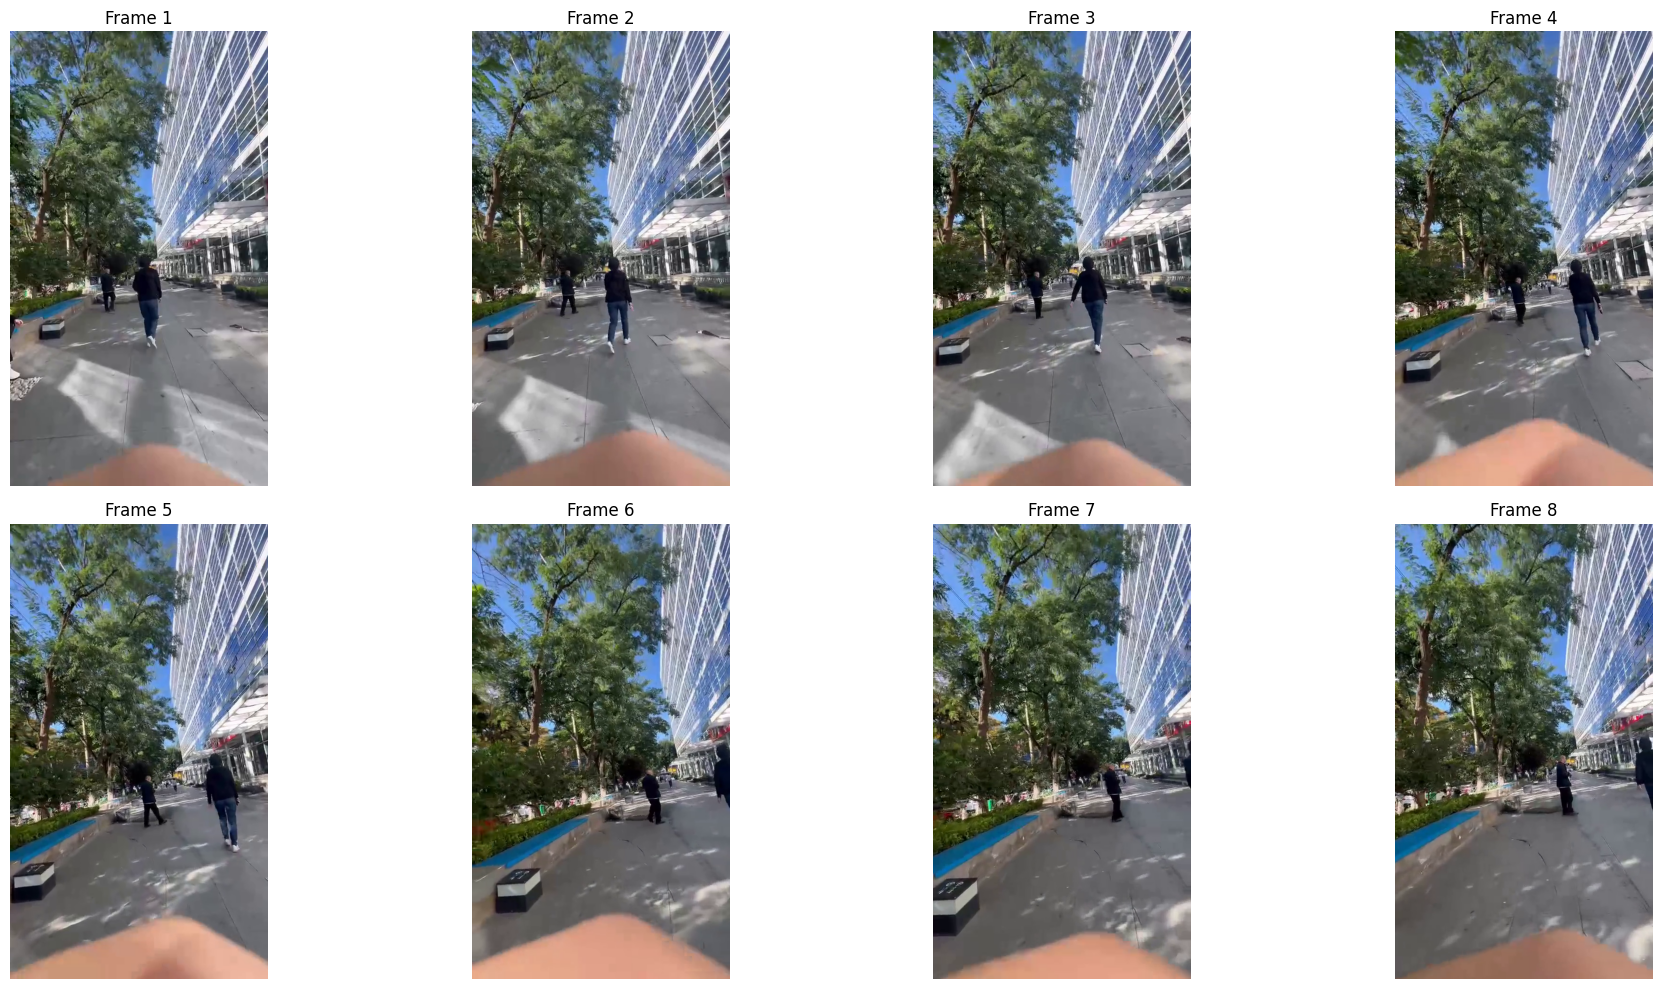

In [20]:
import matplotlib.pyplot as plt
vid = converted_dataset[5]
# 1. Extract only the image objects from your content list
images = [c['image'] for c in vid['messages'][0]['content'] if c['type'] == 'image']

# 2. Plot them in a grid
plt.figure(figsize=(20, 10))
for i, img in enumerate(images):
    plt.subplot(2, 4, i + 1) # 2 rows, 4 columns
    plt.imshow(img)
    plt.title(f"Frame {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3n"
)

In [22]:
# 1. Enable Unsloth optimized inference
FastVisionModel.for_inference(model)

# 2. Select and prepare the video data
sample = dataset[5]
video_path = sample["video"]["path"]
print(f"Evaluating Video: {video_path}")

# FIX: Get frames directly. Since downsample_video returns 
# a list of images, we don't need to index them.
frames = downsample_video(video_path)

# 3. Construct the Multimodal Message
instruction = "Given the visual input from the user's forward perspective, generate exactly one short sentence to guide a visually impaired user by identifying critical obstacles or landmarks, describing their locations using clock directions relative to the user (12 o’clock is straight ahead), including relevant details such as size, material, or distance, and giving one clear action, while prioritizing immediate safety and avoiding any extra explanation."
messages = [{"role": "user", "content": [{"type": "text", "text": instruction}]}]

# Interleave the extracted frames into the message content
for img in frames:
    messages[0]["content"].append({"type": "image", "image": img})

# 4. Apply Chat Template and Process Inputs
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Feed BOTH the text AND the actual images to the processor
inputs = processor(
    images = frames,        # Pass the list of 8 PIL images here
    text = input_text,     
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Evaluating Video: videos/train/20240914_d288d35e621454988dd7d35e19dcaf2e_7m5s.mp4
Tall glass building is to your right, walk forward 10 steps to the right.<end_of_turn>


In [23]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor, max_seq_length=50000),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        # max_steps = 60,
        num_train_epochs = 3,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.001,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 50000,
    )
)

Unsloth: Model does not have a default image size - using 512


In [24]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A40. Max memory = 44.422 GB.
17.758 GB of memory reserved.


In [25]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 3 | Total steps = 375
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 153,681,920 of 8,003,660,112 (1.92% trained)


Step,Training Loss
1,11.728700
2,11.805200
3,4.736100
4,4.170600
5,3.280200
6,2.281300
7,1.988400
8,1.010000
9,0.655300
10,0.452700


train/epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train/grad_norm,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,████████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_flos,1.0050856602821568e+17
train/epoch,3
train/global_step,375
train/grad_norm,0.3795
train/learning_rate,0.0
train/loss,0.1207


In [26]:
wandb.finish()

In [27]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3721.1016 seconds used for training.
62.02 minutes used for training.
Peak reserved memory = 21.246 GB.
Peak reserved memory for training = 3.488 GB.
Peak reserved memory % of max memory = 47.828 %.
Peak reserved memory for training % of max memory = 7.852 %.


In [28]:
# 1. Enable Unsloth optimized inference
FastVisionModel.for_inference(model)

# 2. Select and prepare the video data
sample = dataset[5]
video_path = sample["video"]["path"]
print(f"Evaluating Video: {video_path}")

# FIX: Get frames directly. Since downsample_video returns 
# a list of images, we don't need to index them.
frames = downsample_video(video_path)

# 3. Construct the Multimodal Message
instruction = "Given the visual input from the user's forward perspective, generate exactly one short sentence to guide a visually impaired user by identifying critical obstacles or landmarks, describing their locations using clock directions relative to the user (12 o’clock is straight ahead), including relevant details such as size, material, or distance, and giving one clear action, while prioritizing immediate safety and avoiding any extra explanation."
messages = [{"role": "user", "content": [{"type": "text", "text": instruction}]}]

# Interleave the extracted frames into the message content
for img in frames:
    messages[0]["content"].append({"type": "image", "image": img})

# 4. Apply Chat Template and Process Inputs
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Feed BOTH the text AND the actual images to the processor
inputs = processor(
    images = frames,        # Pass the list of 8 PIL images here
    text = input_text,     
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Evaluating Video: videos/train/20240914_d288d35e621454988dd7d35e19dcaf2e_7m5s.mp4
at 11 o'clock direction, there are pedestrians passing by, pay attention to avoid.<end_of_turn>


In [ ]:
# model.save_pretrained("lora_model")  # Local saving
# processor.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
# if False:
#     from unsloth import FastVisionModel

#     model, processor = FastVisionModel.from_pretrained(
#         model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
#         load_in_4bit=True,  # Set to False for 16bit LoRA
#     )
#     FastVisionModel.for_inference(model)  # Enable for inference!

# FastVisionModel.for_inference(model)  # Enable for inference!

# # 2. Select and prepare the video data
# sample = dataset[2]
# video_path = sample["video"]["path"]
# print(f"Evaluating Video: {video_path}")

# # FIX: Get frames directly. Since downsample_video returns 
# # a list of images, we don't need to index them.
# frames = downsample_video(video_path)

# # 3. Construct the Multimodal Message
# instruction = "What is in these image inputs? Provide navigation advice for the walking path."
# messages = [{"role": "user", "content": [{"type": "text", "text": instruction}]}]

# # Interleave the extracted frames into the message content
# for img in frames:
#     messages[0]["content"].append({"type": "image", "image": img})

# # 4. Apply Chat Template and Process Inputs
# input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# # Feed BOTH the text AND the actual images to the processor
# inputs = processor(
#     images = frames,        # Pass the list of 8 PIL images here
#     text = input_text,     
#     add_special_tokens = False,
#     return_tensors = "pt",
# ).to("cuda")


# from transformers import TextStreamer

# text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
#                    use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
# if False: model.save_pretrained_merged("unsloth_finetune", processor,)

# To export and save to your Hugging Face account
# if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")
model.push_to_hub_merged("blind-assist/gemma-3n-finetune-500train-run-2", processor, token = "")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 4 files from cache to `blind-assist/gemma-3n-finetune-500train-run-2`: 100%|██████████| 4/4 [00:50<00:00, 12.51s/it]


Successfully copied all 4 files from cache to `blind-assist/gemma-3n-finetune-500train-run-2`
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `blind-assist/gemma-3n-finetune-500train-run-2`: 100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


Successfully copied all 1 files from cache to `blind-assist/gemma-3n-finetune-500train-run-2`


Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [00:37<01:51, 37.20s/it]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [01:31<01:34, 47.17s/it]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [02:48<01:01, 61.03s/it]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [03:33<00:00, 53.38s/it]


Unsloth: Merge process complete. Saved to `/workspace/blind-assist/gemma-3n-finetune-500train-run-2`
